In [5]:
#Importing Required Libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from google.cloud import bigquery
import os
import db_dtypes

In [6]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/apple/Downloads/spatial-country-421101-d2bffbc43e88.json"
try:
    client = bigquery.Client()
    print("Authentication successful!")
except Exception as e:
    print("Authentication failed:", e)

Authentication successful!


In [7]:
client = bigquery.Client()
dataset = client.get_dataset('spatial-country-421101.Airlines')

1. Origin and Destination Airport Analysis w.r.t Delay and Cancellations

In [136]:
sql_query = """
  SELECT
    f.ORIGIN_AIRPORT_CODE_ AS Origin_Airport,
    f.DESTINATION_AIRPORT_CODE AS Destination_Airport,
    a.Airport_Name AS Origin_Airport_Name,
    b.Airport_Name AS Destination_Airport_Name,
    SUM(f.NUMBER_OF_FLIGHT_OPERATIONS_NOT_ARRIVING_ON_TIME) AS Total_Delays,
    AVG(f.PERCENT_OF_FLIGHT_OPERATIONS_NOT_ARRIVING_ON_TIME) AS Avg_Percent_Delays,
    SUM(c.Total_Operations) AS Total_Operations,
    SUM(c.Number_Cancelled) AS Total_Cancelled,
    AVG(c.Percent_Cancelled) AS Avg_Percent_Cancelled
FROM
    Airlines.Flight_Info AS f
JOIN
    Airlines.Airport_Info AS a
ON
    f.ORIGIN_AIRPORT_CODE_ = a.Airport_Code
JOIN
    Airlines.Airport_Info AS b
ON
    f.DESTINATION_AIRPORT_CODE = b.Airport_Code
JOIN
    Airlines.Cancelled_Flights AS c
ON
    f.ORIGIN_AIRPORT_CODE_ = c.Origin_Airport_Code
    AND f.DESTINATION_AIRPORT_CODE = c.Destination_Airport_Code
    AND f.MONTH = c.Month
GROUP BY
    f.ORIGIN_AIRPORT_CODE_,
    f.DESTINATION_AIRPORT_CODE,
    a.Airport_Name,
    b.Airport_Name
ORDER BY 
   Avg_Percent_Delays DESC,
   Avg_Percent_Cancelled DESC
LIMIT 10
"""
# Execute the query
df = client.query(sql_query).to_dataframe()

df

,Origin_Airport,Destination_Airport,Origin_Airport_Name,Destination_Airport_Name,Total_Delays,Avg_Percent_Delays,Total_Operations,Total_Cancelled,Avg_Percent_Cancelled
0,DFW,MIA,Dallas/Ft Worth Intl,Miami International Airport,9,90.000,10,1,10.000000
1,MSP,LAX,St Paul Intl,Los Angeles International,39,87.880,54,5,10.583333
2,CLE,ATL,Hopkins International,Hartsfield-Jackson Atlanta Int,57,85.052,83,9,11.326000
3,EWR,DCA,Newark International Airport,Ronald Reagan National,507,84.100,534,124,23.201538
4,EWR,AVP,Newark International Airport,International,52,83.870,62,18,29.025000
5,TTN,RDU,Trenton-Mercer,Raleigh-Durham International Airport,30,83.330,18,5,31.535000
6,FLL,TTN,International,Trenton-Mercer,14,82.350,18,2,11.110000
7,PHX,PDX,Sky Harbor Intl,Portland International,14,82.350,15,1,6.660000
8,FLL,ALB,International,Albany International,13,81.250,24,2,8.330000
9,ATL,HSV,Hartsfield-Jackson Atlanta Int,Huntsville,12,80.000,24,4,16.660000


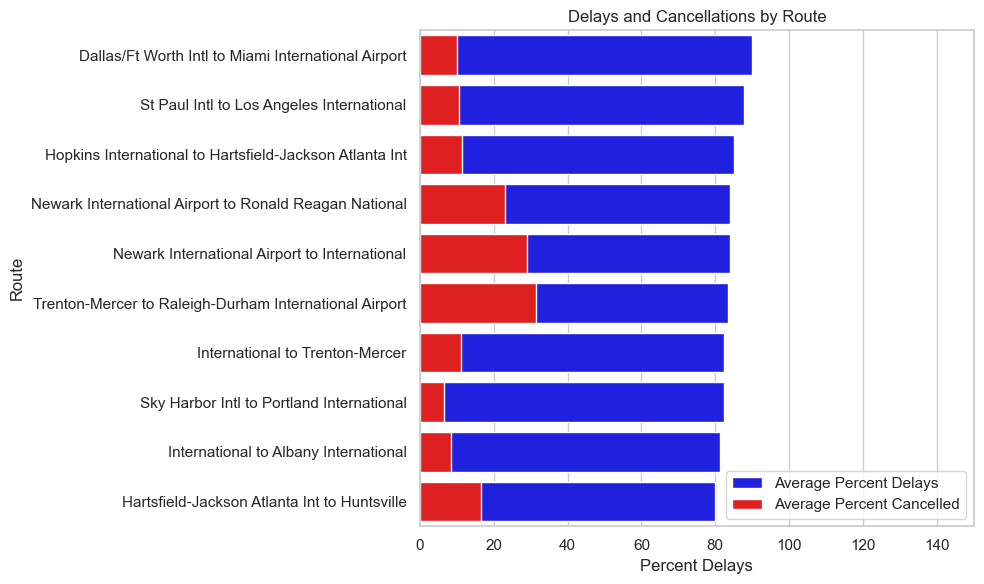

In [137]:
#Visualisations

# Combine origin and destination airport names
df_delays['Route'] = df_delays['Origin_Airport_Name'] + ' to ' + df_delays['Destination_Airport_Name']

# Create a figure for grouped bar charts
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
ax = sns.barplot(data=df_delays, x='Avg_Percent_Delays', y='Route', color='blue', label='Average Percent Delays')
ax = sns.barplot(data=df_delays, x='Avg_Percent_Cancelled', y='Route', color='red', label='Average Percent Cancelled')
plt.title('Delays and Cancellations by Route')
plt.xlabel('Percent Delays')
plt.ylabel('Route')
plt.xlim(0, 150)  # Adjust x-axis limits as needed
plt.xticks(range(0, 150 + 1, 20))
plt.legend(loc='lower right')  # Adjust legend position as needed
plt.tight_layout()
plt.show()

2. Analysis of Delay Reasons

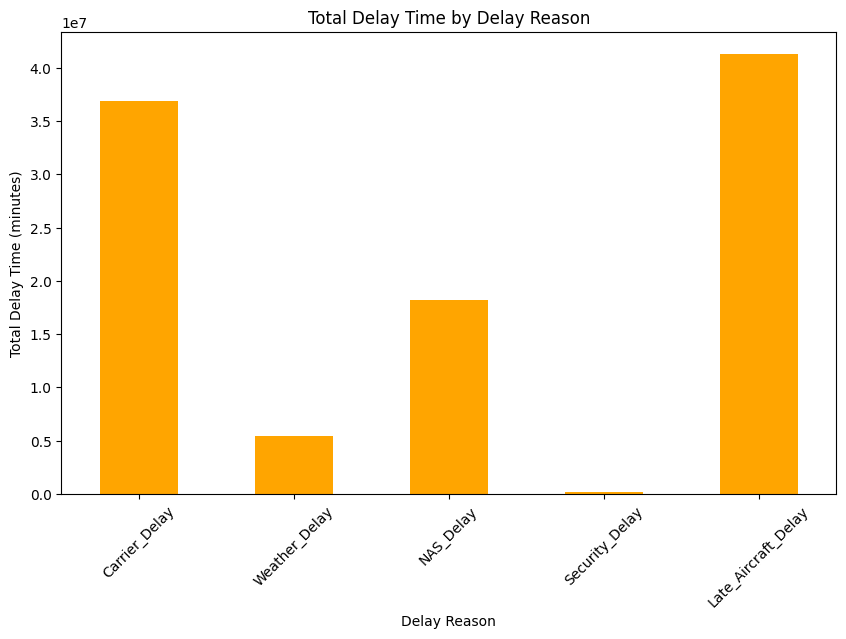

In [35]:
#To retrieve delay reasons 
query = """
SELECT
    SUM(CARRIER_DELAY) AS Carrier_Delay,
    SUM(WEATHER_DELAY) AS Weather_Delay,
    SUM(NAS_DELAY) AS NAS_Delay,
    SUM(SECURITY_DELAY) AS Security_Delay,
    SUM(LATE_AIRCRAFT_DELAY) AS Late_Aircraft_Delay
FROM
    Airlines.Airline_Delay
"""

# Execute the query
df_delay = client.query(query).to_dataframe()

#Visualization
plt.figure(figsize=(10, 6))
df_delay.sum().plot(kind='bar', color='orange')
plt.xlabel('Delay Reason')
plt.ylabel('Total Delay Time (minutes)')
plt.title('Total Delay Time by Delay Reason')
plt.xticks(rotation=45)
plt.show()

Delay reasons for each month and check if any holidays occur in each month that may affect flight delays

In [37]:
query = """
SELECT
    ad.Month,
    SUM(ad.CARRIER_DELAY) AS Carrier_Delay,
    SUM(ad.WEATHER_DELAY) AS Weather_Delay,
    SUM(ad.NAS_DELAY) AS NAS_Delay,
    SUM(ad.SECURITY_DELAY) AS Security_Delay,
    SUM(ad.LATE_AIRCRAFT_DELAY) AS Late_Aircraft_Delay,
    MIN(uh.Name) AS Holiday_Name
FROM
    Airlines.Airline_Delay AS ad
LEFT JOIN
    Airlines.US_Holidays AS uh
ON
    ad.Year = uh.year
    AND ad.Month = uh.Month
WHERE 
  uh.Type = "['Local holiday']"
GROUP BY
    ad.Month
ORDER BY
    ad.Month

"""

# Execute the query
df_query = client.query(query).to_dataframe()
df_query

,Month,Carrier_Delay,Weather_Delay,NAS_Delay,Security_Delay,Late_Aircraft_Delay,Holiday_Name
0,1,30970002,5525926,14512582,265846,33890696,Civil Rights Day
1,2,22604307,2076316,8543722,152130,20710184,Daisy Gatson Bates Day
2,3,25348480,2385770,9172390,138050,25626880,César Chávez Day
3,4,22697872,3286512,12225992,118936,24281216,Arbor Day
4,5,18076445,2601410,7933710,107855,21183815,Confederate Memorial Day
5,6,220987843,38904297,115922868,887689,283841413,Bunker Hill Day
6,7,16561540,2647348,8299800,88640,19722152,Independence Day
7,8,16815924,1970676,7172556,103260,18263022,American Family Day
8,9,42187821,6469827,23854168,255476,49282948,American Indian Day
9,10,44066204,6049680,26091912,257754,50421294,Alaska Day


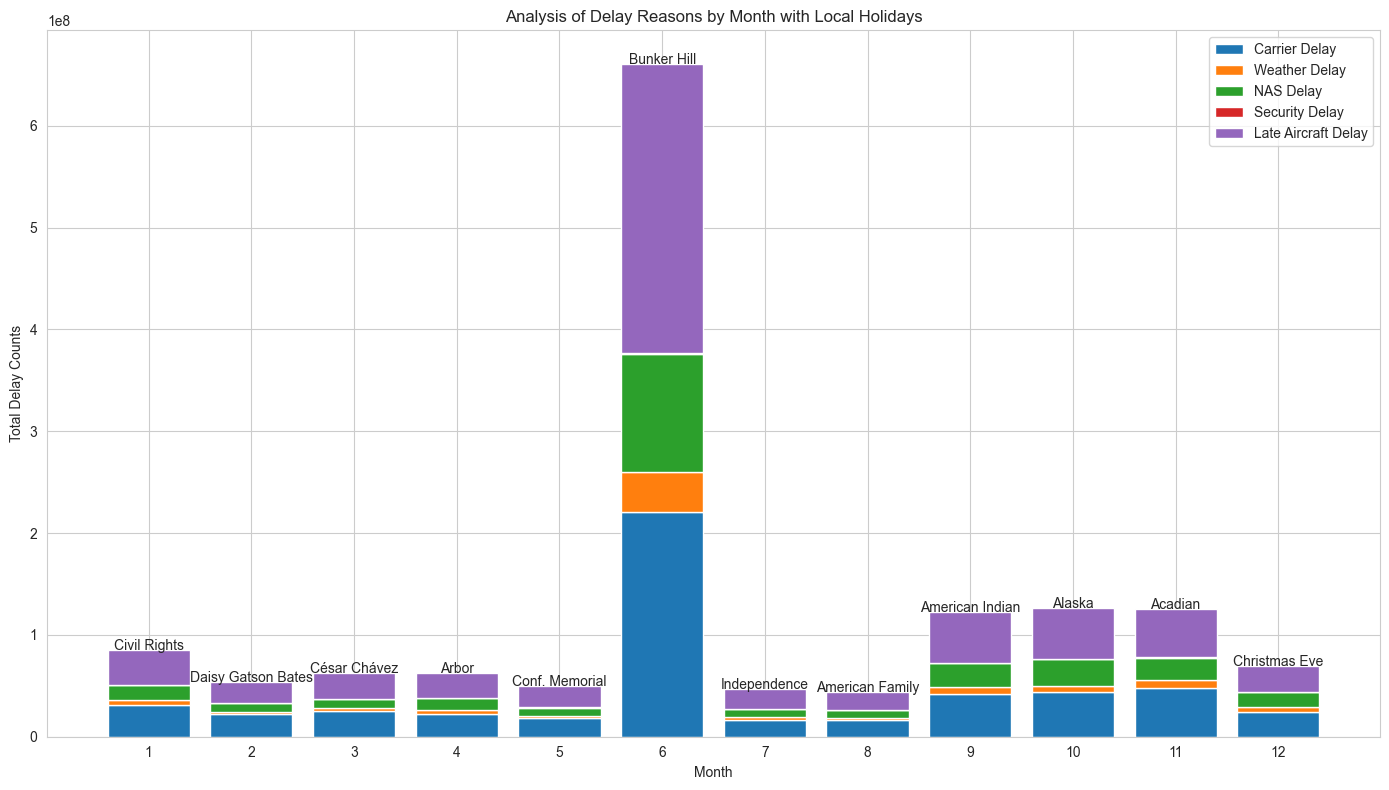

In [72]:


# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure for the stacked bar chart
plt.figure(figsize=(14, 8))

# Create a barplot for each type of delay, stacking them by specifying the bottom parameter
plt.bar(df_query['Month'], df_query['Carrier_Delay'], label='Carrier Delay')
plt.bar(df_query['Month'], df_query['Weather_Delay'], bottom=df_query['Carrier_Delay'], label='Weather Delay')
plt.bar(df_query['Month'], df_query['NAS_Delay'], bottom=df_query['Carrier_Delay'] + df_query['Weather_Delay'], label='NAS Delay')
plt.bar(df_query['Month'], df_query['Security_Delay'], bottom=df_query['Carrier_Delay'] + df_query['Weather_Delay'] + df_query['NAS_Delay'], label='Security Delay')
plt.bar(df_query['Month'], df_query['Late_Aircraft_Delay'], bottom=df_query['Carrier_Delay'] + df_query['Weather_Delay'] + df_query['NAS_Delay'] + df_query['Security_Delay'], label='Late Aircraft Delay')

# Annotate the local holiday names on the bars
for idx, row in df_query.iterrows():
    holiday_name = row['Holiday_Name'].replace(' Day', '')  # Remove 'Day' from holiday names
    holiday_name = holiday_name.replace('Confederate Memorial', 'Conf. Memorial')  # Shorten 'Confederate Memorial' to 'Conf. Memorial'
    plt.text(row['Month'], 
             row['Carrier_Delay'] + row['Weather_Delay'] + row['NAS_Delay'] + row['Security_Delay'] + row['Late_Aircraft_Delay'] + 1000, 
             holiday_name, 
             rotation=0, ha='center')

# Adding labels and title
plt.title('Analysis of Delay Reasons by Month with Local Holidays')
plt.xlabel('Month')
plt.ylabel('Total Delay Counts')

# Set x-axis scale from 1 to 12
plt.xticks(range(1, 13))

# Create a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


3. Analysis of Carrier Performance  : Displaying the most number of Total_delays of Carrier

In [21]:
sql_query_carrier_performance = """
SELECT
    Carrier,
    Carrier_Name,
    SUM(ARR_DEL15) AS Total_Delays,
    SUM(ARR_DELAY) AS Total_Delay_Time,
    SUM(ARR_FLIGHTS) AS Total_Flights,
    SUM(ARR_DELAY) / SUM(ARR_FLIGHTS) AS Avg_Delay_Per_Flight
FROM
    Airlines.Airline_Delay
GROUP BY
    Carrier,
    Carrier_Name
ORDER BY
    Total_Delays DESC
"""

# Execute the query
df_carrier_performance = client.query(sql_query_carrier_performance).to_dataframe()


df_carrier_performance

,Carrier,Carrier_Name,Total_Delays,Total_Delay_Time,Total_Flights,Avg_Delay_Per_Flight
0,UA,United Air Lines Network,235987,12349006,1060970,11.639355
1,9E,Endeavor Air Inc.,139451,12379152,605914,20.430543
2,DL,Delta Air Lines Network,116332,8360940,590862,14.150411
3,AA,American Airlines Network,115982,8353849,556370,15.014916
4,OO,SkyWest Airlines Inc.,99711,7225721,633110,11.413058
5,MQ,Envoy Air,93517,6697012,382828,17.493527
6,WN,Southwest Airlines,91766,5399758,495221,10.903734
7,AS,Alaska Airlines Network,75258,6165515,283305,21.762817
8,C5,CommuteAir LLC dba CommuteAir,71703,4791443,408739,11.722500
9,PT,Piedmont Airlines,62147,4658000,285576,16.310894


/var/folders/9h/b1pwb2j960d0603t66yx57l80000gn/T/ipykernel_8166/154955986.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total_Delays', y='Carrier_Name', data=df_carrier_performance.sort_values('Total_Delays', ascending=False), palette='viridis')
/var/folders/9h/b1pwb2j960d0603t66yx57l80000gn/T/ipykernel_8166/154955986.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Avg_Delay_Per_Flight', y='Carrier_Name', data=df_carrier_performance.sort_values('Avg_Delay_Per_Flight', ascending=False), palette='cividis')


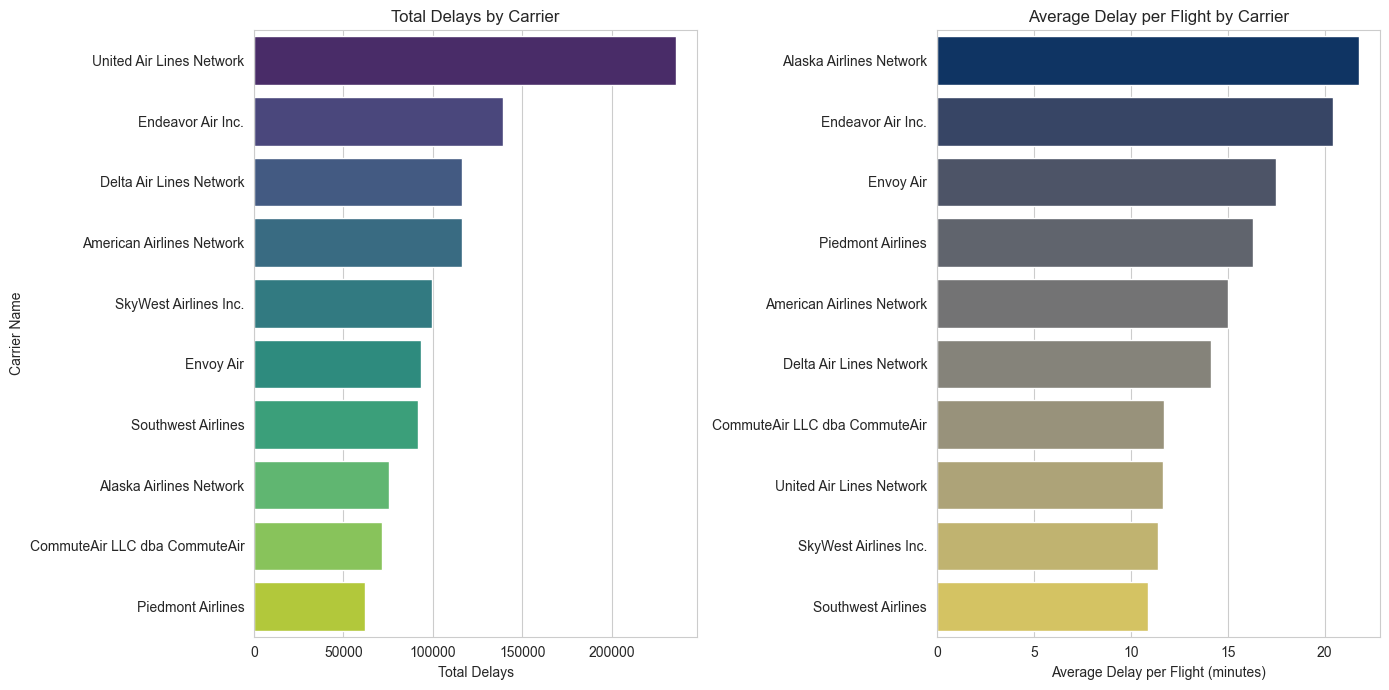

In [22]:
#Visualisation

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure with specified size
plt.figure(figsize=(14, 7))

# Create bar chart for Total Delays by Carrier
plt.subplot(1, 2, 1)
sns.barplot(x='Total_Delays', y='Carrier_Name', data=df_carrier_performance.sort_values('Total_Delays', ascending=False), palette='viridis')
plt.title('Total Delays by Carrier')
plt.xlabel('Total Delays')
plt.ylabel('Carrier Name')

# Create bar chart for Average Delay per Flight by Carrier
plt.subplot(1, 2, 2)
sns.barplot(x='Avg_Delay_Per_Flight', y='Carrier_Name', data=df_carrier_performance.sort_values('Avg_Delay_Per_Flight', ascending=False), palette='cividis')
plt.title('Average Delay per Flight by Carrier')
plt.xlabel('Average Delay per Flight (minutes)')
plt.ylabel('')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


4. To find the top busiest airport for each month and check if any local Holiday associated for each month

In [106]:
query = """
WITH RankedFlights AS (
    SELECT
        fi.MONTH,
        ai.Airport_Name AS Busiest_Airport,
        MIN(ai.City_Name) AS City_Name,
        COUNT(fi.FLIGHT_NUMBER_) AS Total_Flights,
        MIN(hi.Name) AS Holiday_Name,
        ROW_NUMBER() OVER (PARTITION BY fi.MONTH ORDER BY COUNT(fi.FLIGHT_NUMBER_) DESC) AS RowNum
    FROM
        Airlines.Flight_Info fi
    JOIN
        Airlines.Airport_Info ai ON fi.ORIGIN_AIRPORT_CODE_ = ai.Airport_Code
    JOIN 
        Airlines.US_Holidays hi ON fi.MONTH = hi.Month
    WHERE 
        hi.Type = "['Local holiday']"
    GROUP BY
        fi.MONTH,
        ai.Airport_Name
)
SELECT
    MONTH,
    Busiest_Airport,
    City_Name,
    Total_Flights,
    Holiday_Name
FROM
    RankedFlights
WHERE
    RowNum = 1
ORDER BY
    MONTH;
"""
# Execute the query
df = client.query(query).to_dataframe()
df

,MONTH,Busiest_Airport,City_Name,Total_Flights,Holiday_Name
0,1,International,Fort Lauderdale,280,Civil Rights Day
1,2,John F Kennedy Intl,New York,220,Daisy Gatson Bates Day
2,3,International,Fort Lauderdale,590,César Chávez Day
3,4,International,Fort Lauderdale,1008,Arbor Day
4,5,Mccarran Intl,Las Vegas,125,Confederate Memorial Day
5,6,International,El Paso,10058,Bunker Hill Day
6,7,International,Bangor,1080,Independence Day
7,8,International,Fort Lauderdale,522,American Family Day
8,9,International,Fort Lauderdale,455,American Indian Day
9,10,International,Fort Lauderdale,154,Alaska Day


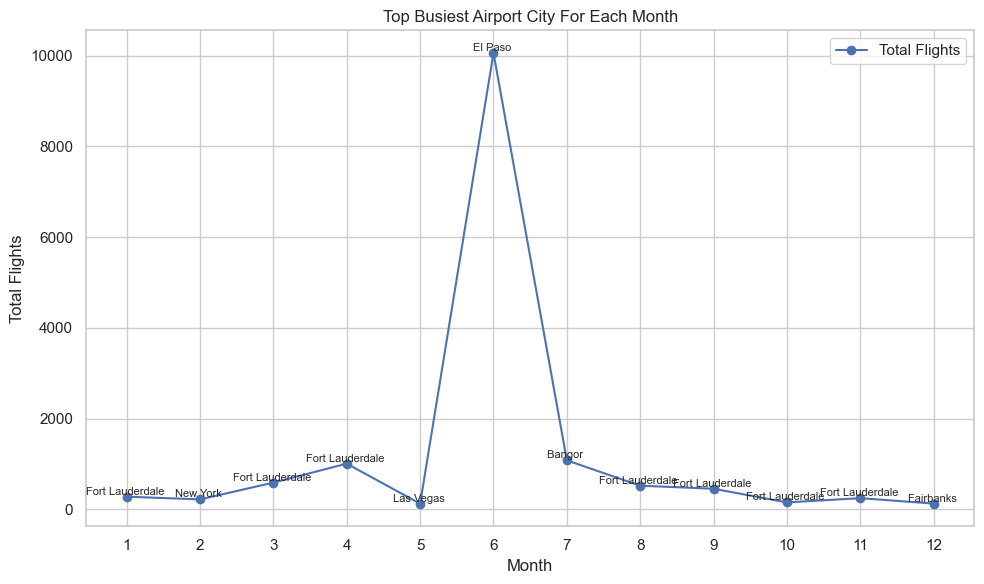

In [130]:

# Plotting
plt.figure(figsize=(10, 6))

# Plot Total Flights
plt.plot(df['MONTH'], df['Total_Flights'], marker='o', color='b', label='Total Flights')

# Highlight holidays
holidays = df[df['Holiday_Name'].notna()]
for _, row in holidays.iterrows():
    plt.text(row['MONTH'], row['Total_Flights'], f"{row['City_Name']} ", ha='center', va='bottom', fontsize=8)

plt.xlabel('Month')
plt.ylabel('Total Flights')
plt.title('Top Busiest Airport City For Each Month')
plt.xticks(df['MONTH'])
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


5. Percentage of Delayed Flights by Carrier and Airport ( Top 10 )

In [131]:
query = """
SELECT
    ad.Carrier,
    MIN(ac.Carrier_Name) AS Carrier_Name,
    ai.Airport_Code,
    MIN(ai.Airport_Name) AS Airport_Name,
    MIN(ai.City_Name) AS City_Name,
    SUM(ad.ARR_DEL15) AS Total_Delayed_Flights,
    SUM(ad.ARR_FLIGHTS) AS Total_Flights,
    ROUND(SAFE_DIVIDE(SUM(ad.ARR_DEL15), SUM(ad.ARR_FLIGHTS)) * 100, 2) AS Percentage_Delayed
FROM
    Airlines.Airline_Delay ad
JOIN
    Airlines.Airport_Info ai
ON
    ad.Airport = ai.Airport_Code
JOIN
   Airlines.Airline_Codes ac
ON
   ad.Carrier = ac.Carrier
GROUP BY
    ad.Carrier,
    ai.Airport_Code
ORDER BY
    Percentage_Delayed DESC
LIMIT 10
"""

# Execute the query
df_query = client.query(query).to_dataframe()
df_query

,Carrier,Carrier_Name,Airport_Code,Airport_Name,City_Name,Total_Delayed_Flights,Total_Flights,Percentage_Delayed
0,YX,Republic Airline,BTR,Ryan,Baton Rouge,1,1,100.00
1,B6,JetBlue Airways,HDN,Yampa Valley,Hayden,31,64,48.44
2,AS,Alaska Airlines Inc.,FAT,Airterminal,Fresno,1975,4584,43.08
3,MQ,Envoy Air,MTJ,Montrose County,Montrose,25,59,42.37
4,YX,Republic Airline,TLH,Tallahassee Regional Airport,Tallahassee,11,27,40.74
5,ZW,Air Wisconsin Airlines Corp,CLT,Douglas,Charlotte,20,53,37.74
6,DL,Delta Air Lines Inc.,MEM,International,Memphis,987,2632,37.50
7,AS,Alaska Airlines Inc.,FLL,International,Fort Lauderdale,2033,5428,37.45
8,AS,Alaska Airlines Inc.,BOS,Logan International,Boston,3253,8699,37.40
9,F9,Frontier Airlines Inc.,MCI,Kansas City International Airport,Kansas City,437,1190,36.72


/var/folders/9h/b1pwb2j960d0603t66yx57l80000gn/T/ipykernel_11926/1598643740.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


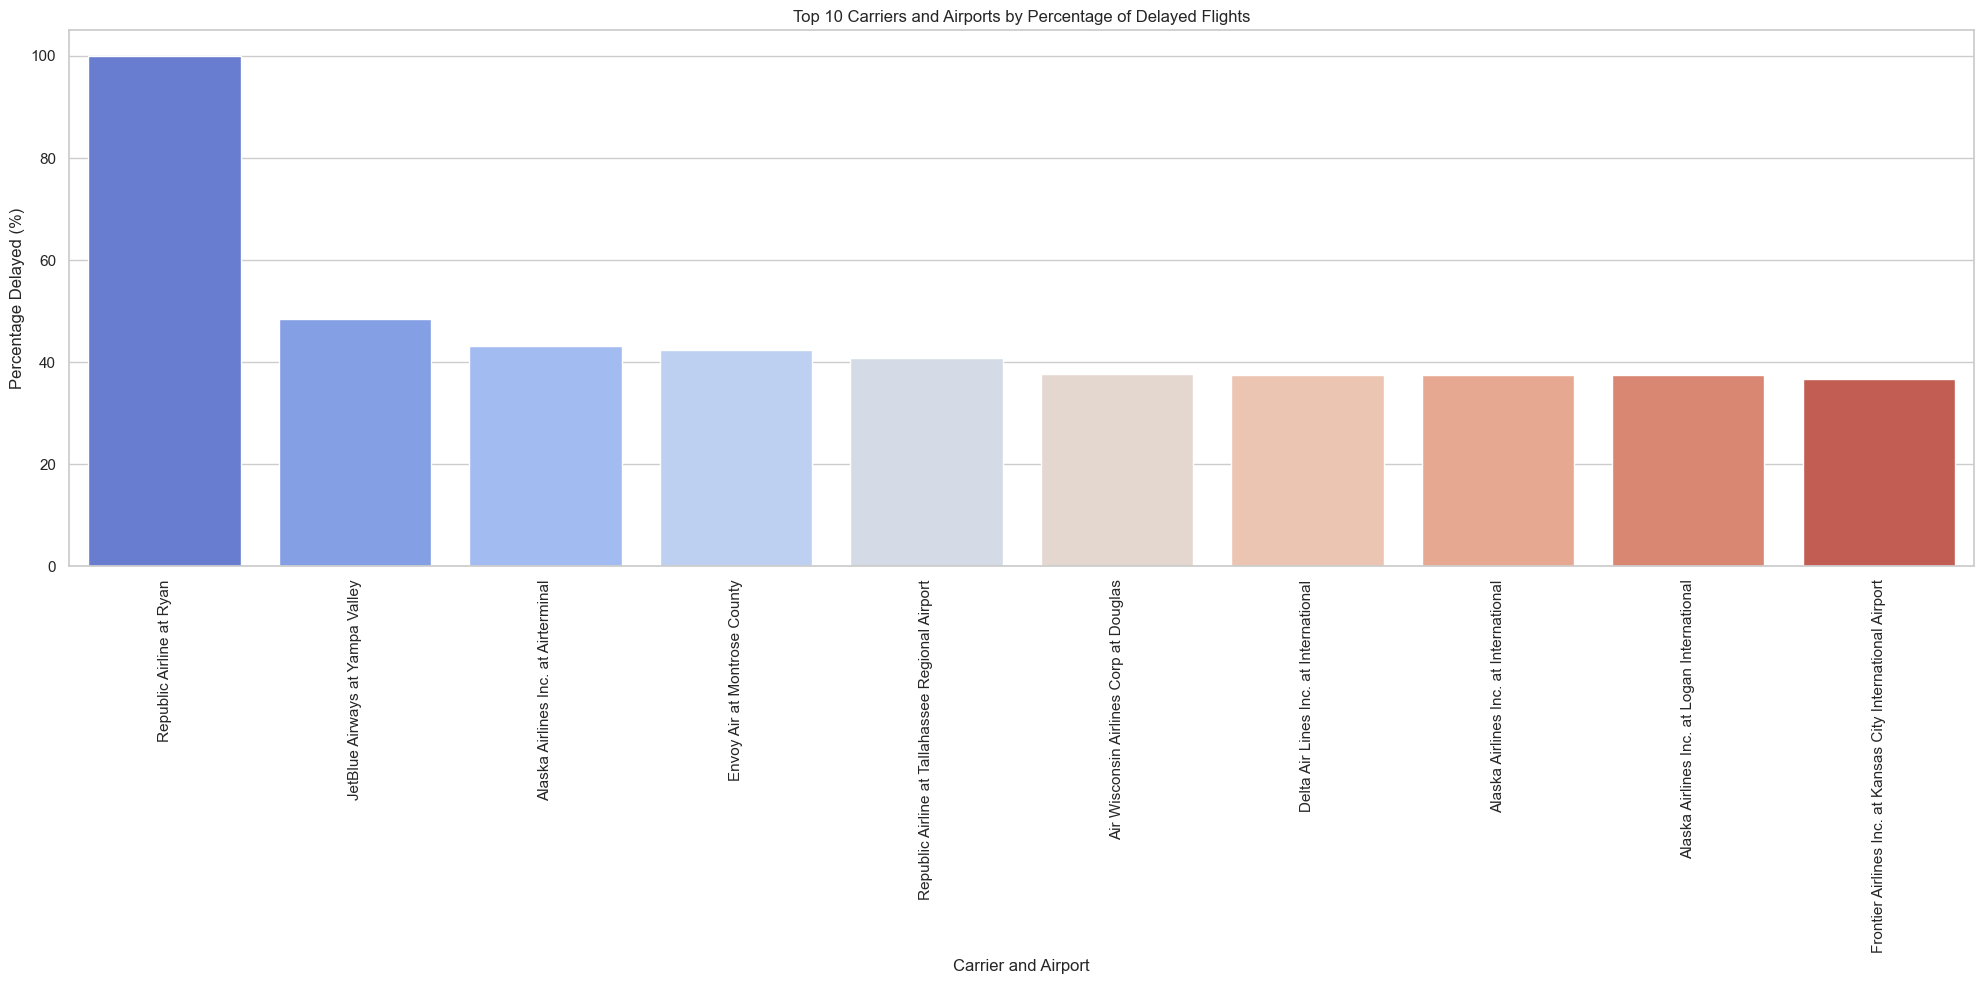

In [132]:
#Visualisations

# combined column that represents both carrier and airport in the bar chart
df_query['Carrier_Airport'] = df_query['Carrier_Name'] + ' at ' + df_query['Airport_Name']

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a bar chart
plt.figure(figsize=(20, 10)) 
barplot = sns.barplot(
    data=df_query,
    x='Carrier_Airport',
    y='Percentage_Delayed',
    palette='coolwarm',  # Use a warm color palette
    order=df_query.sort_values('Percentage_Delayed', ascending=False)['Carrier_Airport']  # Order the bars by percentage delayed
)

# Rotate x-labels
plt.xticks(rotation=90)

# Adding labels and title
plt.title('Top 10 Carriers and Airports by Percentage of Delayed Flights')
plt.xlabel('Carrier and Airport')
plt.ylabel('Percentage Delayed (%)')

# Show the plot
plt.tight_layout()  
plt.show()

6. Percentage of Cancelled Flights by Origin Airport and Carrier ( Top 10)

In [125]:
query = """
SELECT
    cf.Origin_Airport_Code,
    MIN(ai.City_Name) AS City_Name,
    MIN(ai.Airport_Name) AS Airport_Name,
    ac.Carrier_Name AS Carrier_Name,
    SUM(cf.Number_Cancelled) AS Total_Cancelled,
    SUM(cf.Total_Operations) AS Total_Flights,
    ROUND(SAFE_DIVIDE(SUM(cf.Number_Cancelled), SUM(cf.Total_Operations)) * 100, 2) AS Percent_Cancelled
FROM
    Airlines.Cancelled_Flights cf
JOIN
    Airlines.Airline_Codes ac
ON
    cf.Airline = ac.Carrier
JOIN
   Airlines.Airport_Info ai
ON
  cf.Origin_Airport_Code = ai.Airport_Code
GROUP BY
    cf.Origin_Airport_Code,
    ac.Carrier_Name
ORDER BY
    cf.Origin_Airport_Code,
    Percent_Cancelled DESC
    
LIMIT 10
"""

# Execute the query
df_query = client.query(query).to_dataframe()
df_query

,Origin_Airport_Code,City_Name,Airport_Name,Carrier_Name,Total_Cancelled,Total_Flights,Percent_Cancelled
0,ABE,Allentown,Lehigh Valley International,Allegiant Air,7,45,15.56
1,ABE,Allentown,Lehigh Valley International,PSA Airlines Inc.,3,33,9.09
2,ABE,Allentown,Lehigh Valley International,SkyWest Airlines Inc.,3,36,8.33
3,ABI,Abilene,Municipal,Envoy Air,12,140,8.57
4,ABQ,Albuquerque,Albuquerque International,Mesa Airlines Inc.,6,54,11.11
5,ABQ,Albuquerque,Albuquerque International,JetBlue Airways,10,91,10.99
6,ABQ,Albuquerque,Albuquerque International,United Air Lines Inc.,17,174,9.77
7,ABQ,Albuquerque,Albuquerque International,Southwest Airlines Co.,77,799,9.64
8,ABQ,Albuquerque,Albuquerque International,Alaska Airlines Inc.,5,57,8.77
9,ABQ,Albuquerque,Albuquerque International,Envoy Air,2,24,8.33


/var/folders/9h/b1pwb2j960d0603t66yx57l80000gn/T/ipykernel_11926/1355175723.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Airport_Carrier', y='Percent_Cancelled', data=df_query, palette='viridis')


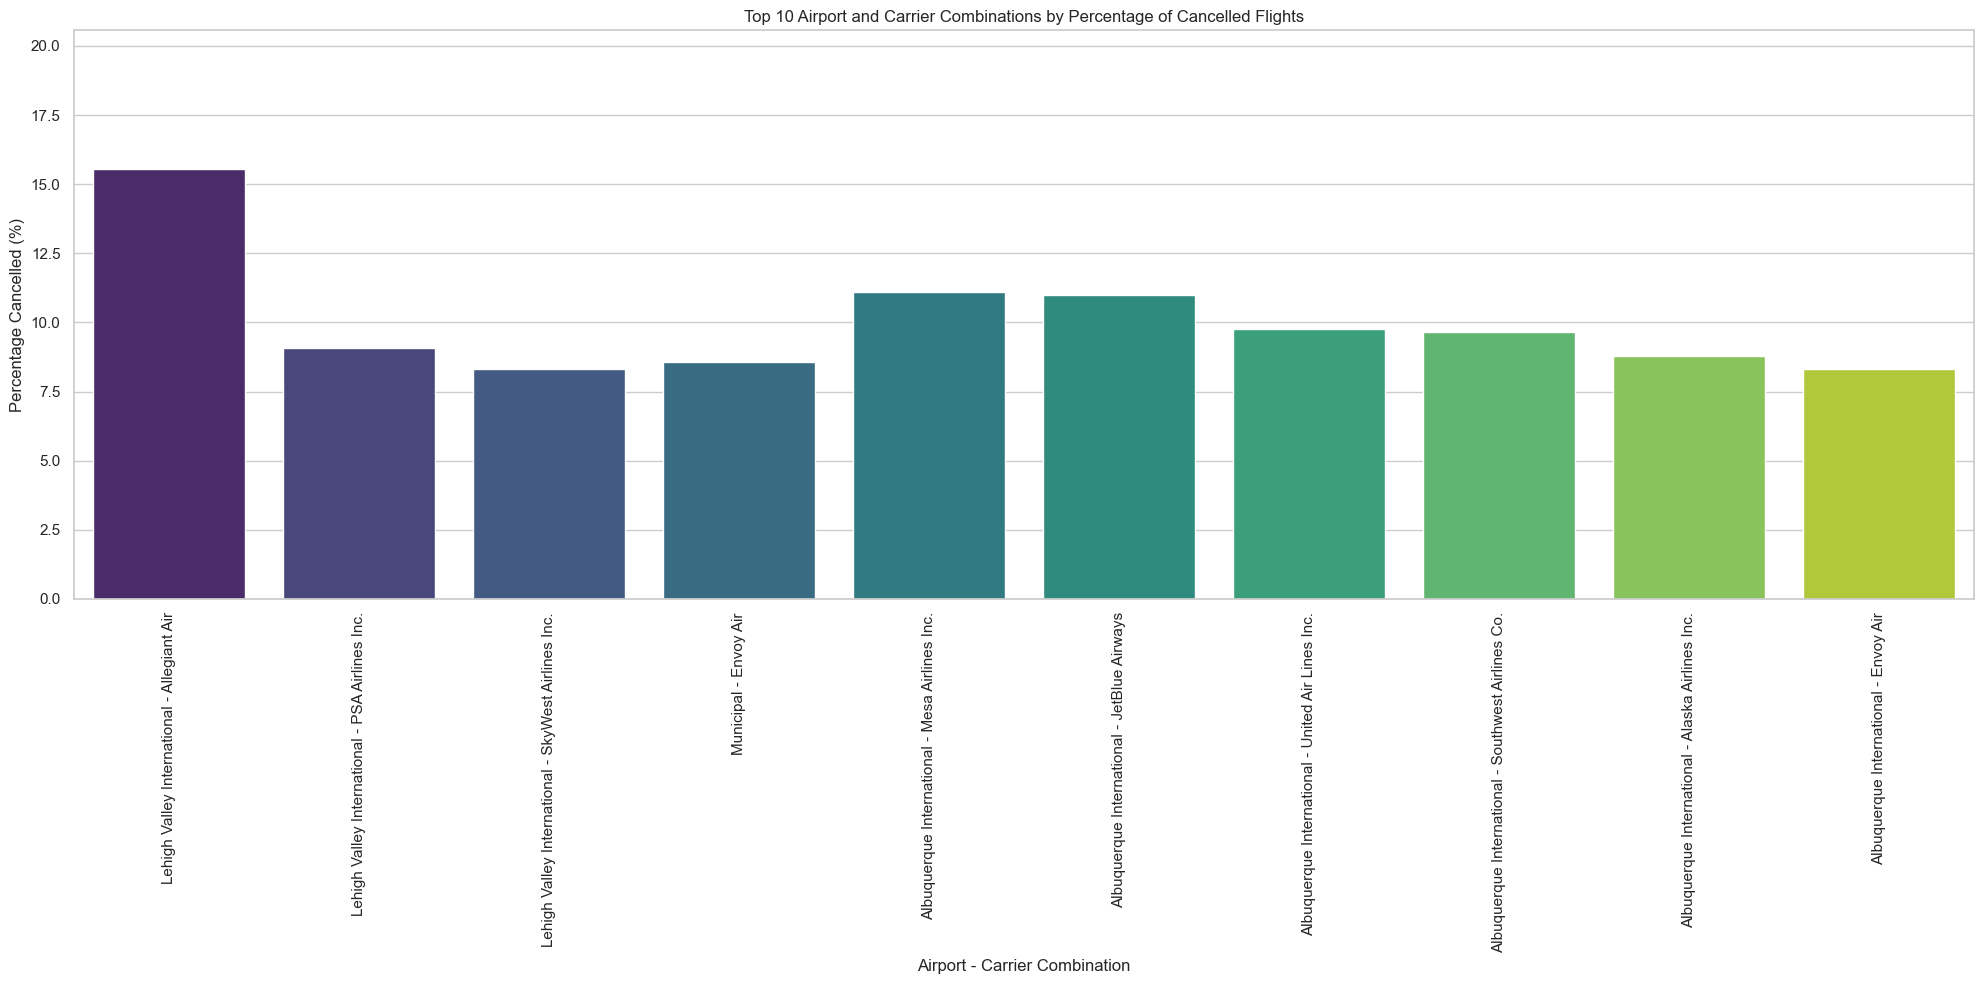

In [128]:
# Visualisation

# Create a new combined column for better clarity in the visualization
df_query['Airport_Carrier'] = df_query['Airport_Name'] + " - " + df_query['Carrier_Name']

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a bar chart
plt.figure(figsize=(20, 10)) 

# Create the barplot 
sns.barplot(x='Airport_Carrier', y='Percent_Cancelled', data=df_query, palette='viridis')

# Set the y-axis limit to match the range of your percentage values
plt.ylim(0, df_query['Percent_Cancelled'].max() + 5) 

# Rotate the x-axis labels to ensure they fit and are readable
plt.xticks(rotation=90)

# Adding labels and title
plt.title('Top 10 Airport and Carrier Combinations by Percentage of Cancelled Flights')
plt.xlabel('Airport - Carrier Combination')
plt.ylabel('Percentage Cancelled (%)')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


In [ ]:
# Statistical Analysis

In [146]:
from scipy.stats import ttest_ind, f_oneway

# 1. Statistical Analysis for Delay and Cancellation Metrics between Different Airports
sql_query_airport1 = """
    SELECT 
        f.ORIGIN_AIRPORT_CODE_ AS Origin_Airport_Code,
        a.Airport_Name AS Origin_Airport_Name,
        SUM(f.NUMBER_OF_FLIGHT_OPERATIONS_NOT_ARRIVING_ON_TIME) AS Total_Delays,
        AVG(f.PERCENT_OF_FLIGHT_OPERATIONS_NOT_ARRIVING_ON_TIME) AS Avg_Percent_Delays,
        SUM(c.Number_Cancelled) AS Total_Cancelled,
        AVG(c.Percent_Cancelled) AS Avg_Percent_Cancelled
    FROM 
        Airlines.Flight_Info AS f
    JOIN 
        Airlines.Airport_Info AS a ON f.ORIGIN_AIRPORT_CODE_ = a.Airport_Code
    JOIN 
        Airlines.Cancelled_Flights AS c ON f.ORIGIN_AIRPORT_CODE_ = c.Origin_Airport_Code
    GROUP BY 
        f.ORIGIN_AIRPORT_CODE_, a.Airport_Name
"""

sql_query_airport2 = """
    SELECT 
        f.DESTINATION_AIRPORT_CODE AS Destination_Airport_Code,
        a.Airport_Name AS Destination_Airport_Name,
        SUM(f.NUMBER_OF_FLIGHT_OPERATIONS_NOT_ARRIVING_ON_TIME) AS Total_Delays,
        AVG(f.PERCENT_OF_FLIGHT_OPERATIONS_NOT_ARRIVING_ON_TIME) AS Avg_Percent_Delays,
        SUM(c.Number_Cancelled) AS Total_Cancelled,
        AVG(c.Percent_Cancelled) AS Avg_Percent_Cancelled
    FROM 
        Airlines.Flight_Info AS f
    JOIN 
        Airlines.Airport_Info AS a ON f.DESTINATION_AIRPORT_CODE = a.Airport_Code
    JOIN 
        Airlines.Cancelled_Flights AS c ON f.DESTINATION_AIRPORT_CODE = c.Origin_Airport_Code
    GROUP BY 
        f.DESTINATION_AIRPORT_CODE, a.Airport_Name
"""

# Execute the SQL queries to fetch the data
df_airport1 = client.query(sql_query_airport1).to_dataframe()
df_airport2 = client.query(sql_query_airport2).to_dataframe()

# Calculate descriptive statistics for delay and cancellation metrics between different airports
mean_delay_airport1 = df_airport1['Total_Delays'].mean()
median_delay_airport1 = df_airport1['Total_Delays'].median()
std_delay_airport1 = df_airport1['Total_Delays'].std()

mean_cancelled_airport1 = df_airport1['Total_Cancelled'].mean()
median_cancelled_airport1 = df_airport1['Total_Cancelled'].median()
std_cancelled_airport1 = df_airport1['Total_Cancelled'].std()

mean_delay_airport2 = df_airport2['Total_Delays'].mean()
median_delay_airport2 = df_airport2['Total_Delays'].median()
std_delay_airport2 = df_airport2['Total_Delays'].std()

mean_cancelled_airport2 = df_airport2['Total_Cancelled'].mean()
median_cancelled_airport2 = df_airport2['Total_Cancelled'].median()
std_cancelled_airport2 = df_airport2['Total_Cancelled'].std()

# Hypothesis testing for delay metrics between different airports
t_statistic_delay, p_value_delay = ttest_ind(df_airport1['Total_Delays'], df_airport2['Total_Delays'])
t_statistic_cancelled, p_value_cancelled = ttest_ind(df_airport1['Total_Cancelled'], df_airport2['Total_Cancelled'])





In [147]:
print("Statistical Analysis for Delay and Cancellation Metrics between Different Airports:")
print("Mean Delay for Airport 1:", mean_delay_airport1)
print("Median Delay for Airport 1:", median_delay_airport1)
print("Standard Deviation of Delay for Airport 1:", std_delay_airport1)
print("Mean Cancelled for Airport 1:", mean_cancelled_airport1)
print("Median Cancelled for Airport 1:", median_cancelled_airport1)
print("Standard Deviation of Cancelled for Airport 1:", std_cancelled_airport1)
print("Mean Delay for Airport 2:", mean_delay_airport2)
print("Median Delay for Airport 2:", median_delay_airport2)
print("Standard Deviation of Delay for Airport 2:", std_delay_airport2)
print("Mean Cancelled for Airport 2:", mean_cancelled_airport2)
print("Median Cancelled for Airport 2:", median_cancelled_airport2)
print("Standard Deviation of Cancelled for Airport 2:", std_cancelled_airport2)
print("T-Statistic for Delay between Airports:", t_statistic_delay)

Statistical Analysis for Delay and Cancellation Metrics between Different Airports:
Mean Delay for Airport 1: 316262.9166666667
Median Delay for Airport 1: 4512.0
Standard Deviation of Delay for Airport 1: 1069851.4285521293
Mean Cancelled for Airport 1: 43843.26282051282
Median Cancelled for Airport 1: 568.0
Standard Deviation of Cancelled for Airport 1: 150801.22067736086
Mean Delay for Airport 2: 259051.43373493975
Median Delay for Airport 2: 4841.0
Standard Deviation of Delay for Airport 2: 823980.6492686098
Mean Cancelled for Airport 2: 36030.78313253012
Median Cancelled for Airport 2: 737.5
Standard Deviation of Cancelled for Airport 2: 120433.40921960033
T-Statistic for Delay between Airports: 0.5394737622211856


Analysis: ( Here Airport1 refers to the origin Airport and Airport2 referes to the destination Airport)
Airport 1 has a higher mean delay (316,262.92 minutes) compared to Airport 2 (259,051.43 minutes).
The median delay for Airport 1 (4,512 minutes) is also higher than Airport 2 (4,841 minutes), indicating that Airport 1 generally experiences longer delays, especially when considering the median value that is less influenced by extreme values.
Both airports have relatively high standard deviations for delay, with Airport 1 having a standard deviation of approximately 1,069,851.43 minutes and Airport 2 having a standard deviation of around 823,980.65 minutes. This indicates a wide variation in delay times at both airports.
Cancellation Metrics:
Airport 1 has a higher mean number of cancellations (43,843.26 flights) compared to Airport 2 (36,030.78 flights).
The median number of cancellations for Airport 1 (568 flights) is also higher than Airport 2 (737.5 flights).
Similar to delay metrics, both airports exhibit considerable variability in the number of cancellations, as indicated by their respective standard deviations.
Hypothesis Testing:
The calculated t-statistic for delay between airports is approximately 0.54, and the associated p-value would help determine if this difference is statistically significant. A low p-value would suggest that the observed difference in delay metrics between the two airports is unlikely to be due to random chance alone, indicating a statistically significant difference.